
# Feature Engineering and Modelling



Main steps from this code:


- import file csv from pre-processing
- extract and engineering features
- build two dataset to train the model, one with target in 2015-06 on another wit target in 2015-05 
- performed feature selection through feature importance on the best performed option
- performed grid research to optimize the model
- prepare the prediction with the 7 best recommendations


(This code needs the data from the EDA_and_PreProcessing)




In [3]:
import csv
import datetime
from operator import sub
import numpy as np
import pandas as pd
import xgboost as xgb
from pandas import Series
from sklearn import preprocessing, ensemble
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import ml_metrics as metrics
from sklearn.grid_search import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection  import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import LogisticRegression


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\acris\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\acris\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [107]:
product_cols = ['ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

# 'ind_ahor_fin_ult1', and ind_aval_fin_ult1' were removed are presented frequencies close to zero

product_names=['Saving_Account','Guarantees','Current_Accounts','Derivada_Account'	'Payroll_Account','Junior_Account','Más_particular_Account','particular_Account','particular_Plus_Account','Short_term_deposits','Medium_term_deposits','Long_term_deposits','e_account','Funds','Mortgage','Pensions','Loans','Taxes','Credit_Card',	'Securities',	'Home_Account','Payroll','Pensions','Direct_Debit']


other_cols=["fecha_dato","ncodpers","ind_empleado","pais_residencia","sexo","age","ind_nuevo","antiguedad","indrel","ult_fec_cli_1t","indrel_1mes","tiprel_1mes","indresi","indext","conyuemp","canal_entrada","indfall","tipodom","cod_prov","ind_actividad_cliente","renta","segmento"
]



In [108]:
df_full=pd.read_csv('train_prePro.csv',  encoding='utf8')

In [109]:
df_test=pd.read_csv('test_prePro.csv',  encoding='utf8')

In [110]:
df_dropProd=pd.read_csv('dropProd.csv', index_col=['ncodpers'])

In [111]:
df_newProd=pd.read_csv('newProd.csv', index_col=['ncodpers'])

Feature engineering
- The Lags t-1, t-2, t-3 for the product owned (suffix _lag1,_lag2, lag3)
- The Lags t-1, t-2, t-3, for the product acquired (suffix _lag1acq,_lag2acq, _lag1acq)
- The period with the previous four months with the number of acquisition for each product (suffix acqLag)
- The period with the previous four months with the number of times the product was dropped (suffix dropLag)

In [112]:
#this function creates the features for both training and test

def CreFeatures(target_date,target_list,lag_list):
    lag_input=df_full[df_full.ncodpers.isin(target_list) & df_full.fecha_dato.isin(lag_list)][['fecha_dato', 'ncodpers']+product_cols ]
    lag_1= lag_input[lag_input.fecha_dato==lag_list[2]].drop('fecha_dato', axis=1).set_index('ncodpers').add_suffix('_lag1')
    lag_2= lag_input[lag_input.fecha_dato==lag_list[1]].drop('fecha_dato', axis=1).set_index('ncodpers').add_suffix('_lag2')
    lag_3= lag_input[lag_input.fecha_dato==lag_list[0]].drop('fecha_dato', axis=1).set_index('ncodpers').add_suffix('_lag3')
    #lag_long=df_full[df_full.ncodpers.isin(target_list)][[ 'ncodpers']+product_cols ].sum()
    
    lag_input_acq=df_newProd[df_newProd.index.isin(target_list) & df_newProd.fecha_dato.isin(lag_list) ][['fecha_dato']+product_cols ].reset_index(drop=False)
    lag_1_acq= lag_input_acq[lag_input_acq.fecha_dato==lag_list[2]].drop('fecha_dato', axis=1).set_index('ncodpers').add_suffix('_lag1acq')
    lag_2_acq= lag_input_acq[lag_input_acq.fecha_dato==lag_list[1]].drop('fecha_dato', axis=1).set_index('ncodpers').add_suffix('_lag2acq')
    lag_3_acq= lag_input_acq[lag_input_acq.fecha_dato==lag_list[0]].drop('fecha_dato', axis=1).set_index('ncodpers').add_suffix('_lag3acq')
    
    
    acqLag=df_newProd[df_newProd.index.isin(target_list) & df_newProd.fecha_dato.isin(lag_list_long) ][product_cols ].reset_index(drop=False).groupby('ncodpers').sum().add_suffix('_acqLag')

    dropLag=df_dropProd[df_dropProd.index.isin(target_list) & df_dropProd.fecha_dato.isin(lag_list_long) ][product_cols ].reset_index(drop=False).groupby('ncodpers').sum().add_suffix('_dropLag')


   
    
    if target_date=='2016-06-28':
        feat=df_test[other_cols][df_test.ncodpers.isin(target_list) & df_test.fecha_dato.isin([target_date]) ].drop('fecha_dato', axis=1).set_index('ncodpers')
    else:
        feat=df_full[other_cols][df_full.ncodpers.isin(target_list) & df_full.fecha_dato.isin([target_date]) ].drop('fecha_dato', axis=1).set_index('ncodpers')
        
    df_x=pd.concat([feat,lag_1,lag_2,lag_3,lag_1_acq,lag_2_acq,lag_3_acq,acqLag,dropLag], axis='columns').reindex(target_list).fillna(0)
    return df_x ,df_x.columns
    
    

In [113]:
#This creates the target variables for training. Here is used the file df_newProd created in pre-process
#this code transforms the 22 binary varibles in a number that rapresent the
def CreTargetTrain(target_date):
    target=df_newProd[df_newProd.fecha_dato==target_date][['fecha_dato']+product_cols]
    target_list=[]
    product_list=[]
    for index, row in target.drop('fecha_dato', axis=1).reset_index(drop = False).iterrows():
        #print(row[0])
        for i , a in enumerate(row):
            if a==1:
                #print (i,a)
                target_list.append(row[0])
                product_list.append(i-1)
    #s=list(zip(id,pr))
    return target_list , product_list

#### Training and target period selection

The code use 2015-06 as target for the training. However, also a model with target for 2016-05 were tested. The results was 0.0195 ( quite low rispect to 2015-06, that was around 0.026 for the initial model) 

In [114]:
##This part creates training data. The codes can extract any period selected.Just change the periods in target list, lag_list and lag_list_long

target_date='2015-06-28'
lag_list=['2015-03-28','2015-04-28','2015-05-28']
lag_list_long=['2015-02-28','2015-03-28','2015-04-28','2015-05-28']
target_list,product_list=CreTargetTrain(target_date)
train_Y=np.array(product_list)
train_Xdf, list_features=CreFeatures( target_date,target_list,lag_list )
train_X=np.array(train_Xdf)


# target_date='2016-05-28'
# lag_list=['2016-02-28','2016-03-28','2016-04-28']
# lag_list_long=['2016-01-28','2016-02-28','2016-03-28','2016-04-28']
# target_list,product_list=CreTargetTrain(target_date)
# train_Y=np.array(product_list)
# train_Xdf, list_features=CreFeatures( target_date,target_list,lag_list )
# train_X=np.array(train_Xdf)

In [115]:
#This part create test data. The codes can extract any period selected.Just change the periods in target list, lag_list and lag_list_long
target_date='2016-06-28'
lag_list=['2016-03-28','2016-04-28','2016-05-28']
lag_list_long=['2016-02-28','2016-03-28','2016-04-28','2016-05-28']
target_list=list(df_test.ncodpers)
test_Xdf,list_test=CreFeatures( target_date,target_list,lag_list )
test_X=np.array(test_Xdf)



In [94]:
del df_test
del df_full
del df_dropProd
del df_newProd

In [117]:
print (train_X.shape, train_Y.shape, test_X.shape)

(45679, 196) (45679,) (929615, 196)


### An initial model was created to perform a feature selection baset on features importance


In [21]:
xgbMatrix = xgb.DMatrix(data=train_X, label=train_Y)
params={
"objective":"multi:softprob",
"eta": 0.05,
"silent": 1,
"max_depth":10,
"subsample" : 0.6815,
"num_class":22}
cv_results = xgb.cv(dtrain=xgbMatrix , params=params, nfold=4, num_boost_round=10, metrics="mlogloss", seed=1)


In [26]:
cv_results

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,2.828300,0.002817,2.821801,0.001868
1,2.646020,0.004688,2.633622,0.002649
2,2.503456,0.006011,2.485806,0.003186
3,2.386552,0.006976,2.363682,0.003832
4,2.286866,0.008114,2.258739,0.003951
5,2.200597,0.008951,2.167454,0.004079
6,2.124266,0.009946,2.086243,0.004178
7,2.056152,0.010431,2.013249,0.004363
8,1.994328,0.010883,1.946974,0.004619
9,1.938471,0.011513,1.886768,0.004677


In [18]:
modXgb = xgb.XGBClassifier(metrics="mlogloss", 
objective='multi:softprob',
eta= 0.05,
silent= 1,
max_depth=10,
subsample = 0.6815,
num_class=22,
seed=1)


modXgb.fit(train_X,train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.05, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, metrics='mlogloss',
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=22, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1, silent=1, subsample=0.6815)

In [22]:
fetDF

,feature,importance
18,renta,0.187284
5,antiguedad,0.142154
3,age,0.140244
16,cod_prov,0.083756
13,canal_entrada,0.051926
2,sexo,0.021772
19,segmento,0.016950
20,ind_cco_fin_ult1_lag1,0.012168
41,ind_recibo_ult1_lag1,0.010530
195,ind_recibo_ult1_dropLag,0.009753


In [96]:
importances=modXgb.feature_importances_
features=list_features
fetDF=pd.concat([Series(features),Series(importances) ], axis='columns').sort_values(by=1,ascending=False)
fetDF.columns = ['feature', 'importance']

zero_imp=fetDF[fetDF.importance==0]
print(zero_imp)

                       feature  importance
177  ind_ctju_fin_ult1_dropLag         0.0
7               ult_fec_cli_1t         0.0
15                     tipodom         0.0
189  ind_reca_fin_ult1_dropLag         0.0
10                     indresi         0.0
12                    conyuemp         0.0
192   ind_viv_fin_ult1_dropLag         0.0
8                  indrel_1mes         0.0
160   ind_deme_fin_ult1_acqLag         0.0
87   ind_cder_fin_ult1_lag1acq         0.0
111  ind_ctju_fin_ult1_lag2acq         0.0
122  ind_pres_fin_ult1_lag2acq         0.0
120   ind_hip_fin_ult1_lag2acq         0.0
133  ind_ctju_fin_ult1_lag3acq         0.0
116  ind_deme_fin_ult1_lag2acq         0.0
138  ind_deme_fin_ult1_lag3acq         0.0
142   ind_hip_fin_ult1_lag3acq         0.0
144  ind_pres_fin_ult1_lag3acq         0.0
148   ind_viv_fin_ult1_lag3acq         0.0
109  ind_cder_fin_ult1_lag2acq         0.0
170    ind_viv_fin_ult1_acqLag         0.0
104   ind_viv_fin_ult1_lag1acq         0.0
155   ind_c

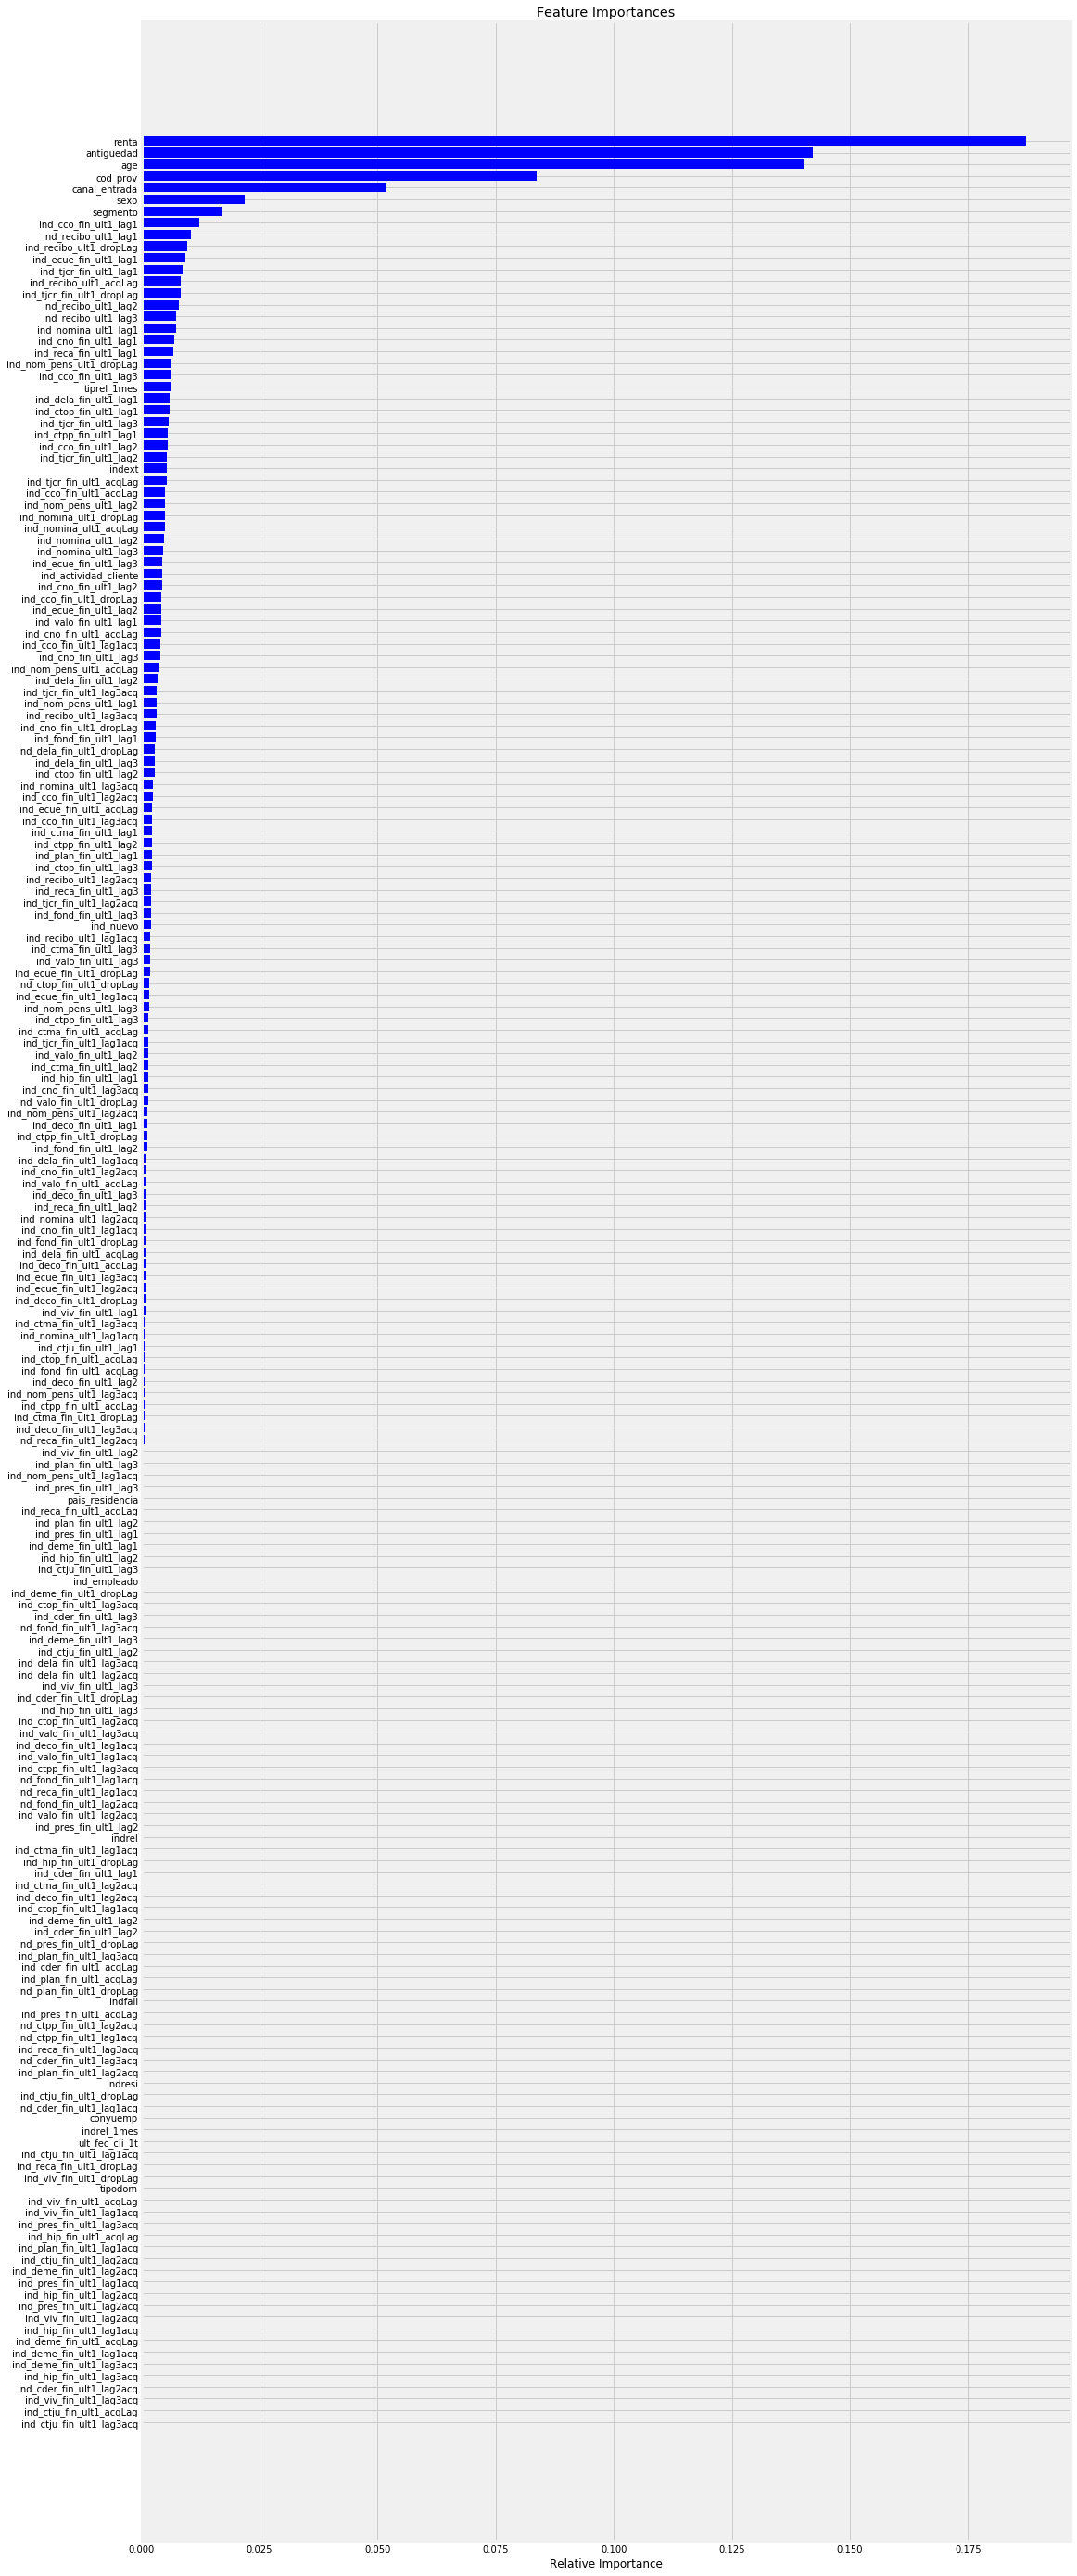

In [21]:
plt.figure(figsize=(16, 50))


indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
 train_Xdf.drop(zero_imp['feature'] , axis=1  )

In [97]:
##########################
#PLEASE NOTICE that in the best submission (score 0.0298528) I did not run this peace of code. The result was better without remuving the variables with low importance. 
############
train_X=np.array( train_Xdf.drop(zero_imp['feature'] , axis=1  ) )
test_X=np.array( test_Xdf.drop(zero_imp['feature'] , axis=1  ))

### GridSearchCV is used to find the best parameters for the final model

In [56]:

#define the params range
param_test1 = {
     'objective': ['multi:softprob'],
    'subsample': [0.5,0.7,0.8],
     'colsample_bytree' : [ 0.6,0.7],
     'max_depth':[8],
     'eta': [0.04],
     'min_child_weight': [3]
  
     } 
 #  'num_class' : [21,22,23]

# {'eta': 0.04,
# 'max_depth': 8,
# 'min_child_weight': 3,
# 'objective': 'multi:softprob'}



In [64]:
#define the GridSearchCV using the alg defined above  
Xsearch = GridSearchCV(estimator =modXgb , param_grid = param_test1, scoring='neg_log_loss', n_jobs=2,   cv=2)

In [ ]:
Xsearch.fit(train_X,train_Y)

In [ ]:
#These are best parameters for the final model
Xsearch.best_params_

In [118]:
def runMod(train_X, train_y, seed_val=0):
    seed_val=100
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.04
    param['max_depth'] = 8
    param['silent'] = 1
    param['num_class'] = 22
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 3
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 50

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)	
    return model


In [119]:
model = runMod(train_X, train_Y, seed_val=0)
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)

In [120]:
print (train_X.shape, train_Y.shape, test_X.shape)

(45679, 196) (45679,) (929615, 196)


In [121]:
#prepare the prediction with the 7 reccomandtion
target_cols = np.array(product_cols)
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:,:7]
test_id = np.array(pd.read_csv( "test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]

out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})



In [122]:
#ouptup for kagle submission

out_df.to_csv('sub_'+datetime.now().strftime("%Y%m%d_%H%M%S")+'.csv', index=False)


# a=train_Xdf.drop(zero_imp['feature'] , axis=1


## BEST SCORE: 0.0298528 (MAP@7 on Kaggle website)